# Title
The title of the notebook should be coherent with file name. Namely, file name should be:    
*author's initials_progressive number_title.ipynb*    
For example:    
*EF_01_Data Exploration.ipynb*

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Import libraries
import os
from pathlib import Path
import sklearn
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from ydata_profiling import ProfileReport, compare

In [2]:
import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

In [3]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
sns.set()

In [4]:
#hydra.core.global_hydra.GlobalHydra.instance().clear()
with initialize(config_path="../../conf", job_name="prediction", version_base="1.2"):
    conf = compose(config_name="config.yaml", return_hydra_config=True)

In [26]:
plot_param_training = dict(label='Training Data',alpha=0.7, color='#bed8fd', edgecolors='#277cf7', s=20,  marker="o")
plot_param_test = dict(label='Test Data', alpha=0.7, color='#e8c5eb', edgecolors='#b94fc4', s=20,  marker="o")
plot_param_expected = dict(color = '#6c9331', alpha=0.9, linewidth=1, linestyle='dashed' ,label='Perfect Fit')

## Load dataset

### Load pre-processed dataset

In [5]:
from src.data.data_loader import DataSet, DatasetProperties
from src.utils.common import UtilsCommon, Features

In [6]:
f_data_cleaned = Path(os.path.join(UtilsCommon.get_project_root(), conf.loc_dirs.dir_data, conf.loc_dirs.f_name_data_feature_target_clean+'.tsv'))

ds_prop_cleaned = DatasetProperties(file_path=f_data_cleaned)
ds_cleaned =  DataSet(props=ds_prop_cleaned, delimiter='\t', index_col=[0])

ds_cleaned.prop.feature_columns = Features.get_feature_columns()
ds_cleaned.prop.target_cols = Features.get_target_columns()

## Normalization and Train Test Split

### Original Dataset

In [7]:
from src.data.preprocessing import PreprocessingConfig, Preprocessing, NormalizationMethod, MissingValueMethod, OversamplingMethod
ds_cleaned.train_val_test_split(test_size=0.2, val_size=0.0, random_state=conf.project_var.seed_random)

config_preprocess = PreprocessingConfig(normalization= NormalizationMethod.STANDARD,
                                        missing_values=MissingValueMethod.MEAN, 
                                        oversampler=OversamplingMethod.SMOTE)

preprocessor_org = Preprocessing(config=config_preprocess)
x_train_norm, x_test_norm = preprocessor_org.normalize(X_train = ds_cleaned.X_train, X_test=ds_cleaned.X_test)

## ML Algos

In [8]:
from src.evaluation.metrics import Metrics, MetricName
evaluation_mat = [
    MetricName.MEAN_SQUARED_ERROR,
    MetricName.ROOT_MEAN_SQUARED_ERROR,
    MetricName.R2_SCORE,
    MetricName.MEAN_ABSOLUTE_ERROR,
    MetricName.MEDIAN_ABSOLUTE_ERROR,
    # MetricName.MEAN_SQUARED_LOG_ERROR,
    MetricName.MEAN_ABSOLUTE_PERCENTAGE_ERROR
]

### Line width

In [108]:
from  src.models.neural_net import NeuralNetConfig, NeuralNet
from src.evaluation.metrics import Metrics, MetricName
config_mlp_relu = NeuralNetConfig(
    ml_platform='sklearn',
    ml_algo='mlp',
    model_params={'alpha': 0.01, 'learning_rate': 0.0001},
    hidden_layer_size=30,
    activation='relu',
    optimizer='lbfgs',
    epochs=500,
    batch_size=32,
    loss='mse',
)
model_mlp_relu_lw = NeuralNet(config_mlp_relu)

In [109]:
model_mlp_relu_lw.train(x_train_norm, ds_cleaned.y_train['line_width'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69518D+04    |proj g|=  2.28292D+02

At iterate    1    f=  1.46999D+03    |proj g|=  3.84048D+02

At iterate    2    f=  9.12948D+02    |proj g|=  2.47413D+02

At iterate    3    f=  4.47253D+02    |proj g|=  6.00933D+01

At iterate    4    f=  3.99364D+02    |proj g|=  3.93761D+01

At iterate    5    f=  3.87024D+02    |proj g|=  3.06504D+01

At iterate    6    f=  3.67809D+02    |proj g|=  2.49028D+01

At iterate    7    f=  3.56870D+02    |proj g|=  3.67077D+01

At iterate    8    f=  3.46866D+02    |proj g|=  2.26810D+01

At iterate    9    f=  3.35108D+02    |proj g|=  1.05161D+01

At iterate   10    f=  3.30202D+02    |proj g|=  1.11374D+01

At iterate   11    f=  3.21170D+02    |proj g|=  8.15397D+00

At iterate   12    f=  3.10606D+02    |proj g|=  2.82304D+01

At iterate   13    f=  3.0

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate  401    f=  2.25781D+02    |proj g|=  2.20485D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    401    510      1     0     0   2.205D+00   2.258D+02
  F =   225.78067478634932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [110]:
y_train_pred_lw =  model_mlp_relu_lw.predict(x_train_norm)
y_test_pred_lw =  model_mlp_relu_lw.predict(x_test_norm)

In [111]:
from sklearn.model_selection import cross_val_score
cv_scores_lw = cross_val_score(model_mlp_relu_lw.model, ds_cleaned.data[Features.get_feature_columns()], ds_cleaned.data[Features.get_target_columns()[0]], cv=10)

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56480D+04    |proj g|=  1.04629D+05

At iterate    1    f=  1.32377D+03    |proj g|=  6.47888D+03

At iterate    2    f=  1.14552D+03    |proj g|=  8.00686D+02

At iterate    3    f=  1.14261D+03    |proj g|=  4.15560D+01

At iterate    4    f=  1.13536D+03    |proj g|=  2.54480D+02

At iterate    5    f=  1.06090D+03    |proj g|=  1.87396D+03

At iterate    6    f=  1.03366D+03    |proj g|=  9.65213D+02

At iterate    7    f=  9.60462D+02    |proj g|=  2.95090D+03

At iterate    8    f=  9.29671D+02    |proj g|=  3.29057D+02

At iterate    9    f=  9.21814D+02    |proj g|=  5.29729D+03

At iterate   10    f=  9.13584D+02    |proj g|=  2.73727D+03

At iterate   11    f=  9.11030D+02    |proj g|=  1.86600D+02

At iterate   12    f=  9.10843D+02    |proj g|=  1.15989D+02

At iterate   13    f=  9.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   63    f=  6.36939D+02    |proj g|=  5.81251D+03

At iterate   64    f=  6.35836D+02    |proj g|=  3.49079D+03

At iterate   65    f=  6.35335D+02    |proj g|=  1.42755D+03

At iterate   66    f=  6.35173D+02    |proj g|=  2.50060D+03

At iterate   67    f=  6.35153D+02    |proj g|=  1.98926D+03

At iterate   68    f=  6.35123D+02    |proj g|=  1.15539D+03

At iterate   69    f=  6.35100D+02    |proj g|=  1.31228D+03

At iterate   70    f=  6.35096D+02    |proj g|=  2.59282D+02

At iterate   71    f=  6.35092D+02    |proj g|=  2.36666D+02

At iterate   72    f=  6.35092D+02    |proj g|=  2.36158D+02

At iterate   73    f=  6.35092D+02    |proj g|=  3.18896D+02

At iterate   74    f=  6.35036D+02    |proj g|=  1.81441D+03

At iterate   75    f=  6.34844D+02    |proj g|=  2.90952D+03

At iterate   76    f=  6.34548D+02    |proj g|=  3.23006D+03

At iterate   77    f=  6.33988D+02    |proj g|=  8.21371D+03

At iterate   78    f=  6.29765D+02    |proj g|=  1.34776D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate  167    f=  5.05383D+02    |proj g|=  3.97317D+03

At iterate  168    f=  5.05183D+02    |proj g|=  1.17640D+03

At iterate  169    f=  5.04943D+02    |proj g|=  4.03188D+03

At iterate  170    f=  5.04888D+02    |proj g|=  1.93763D+03

At iterate  171    f=  5.04874D+02    |proj g|=  1.49266D+03

At iterate  172    f=  5.04817D+02    |proj g|=  1.07923D+03

At iterate  173    f=  5.04732D+02    |proj g|=  3.31622D+03

At iterate  174    f=  5.04543D+02    |proj g|=  6.41537D+03

At iterate  175    f=  5.04190D+02    |proj g|=  8.94513D+03

At iterate  176    f=  5.03724D+02    |proj g|=  1.05114D+04

At iterate  177    f=  5.03613D+02    |proj g|=  8.29476D+03

At iterate  178    f=  5.03287D+02    |proj g|=  5.24056D+03

At iterate  179    f=  5.03087D+02    |proj g|=  2.54568D+03

At iterate  180    f=  5.03055D+02    |proj g|=  4.12064D+03

At iterate  181    f=  5.02971D+02    |proj g|=  5.82365D+03

At iterate  182    f=  5.02892D+02    |proj g|=  5.93595D+03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [112]:
cv_scores_lw

array([ 0.32865766,  0.57690378, -0.35838931,  0.57495944,  0.60630116,
        0.1738667 ,  0.07853542,  0.29032693, -0.1746678 , -1.47132211])

In [113]:
model_mlp_relu_eval_train_lw = model_mlp_relu_lw.evaluate(x_train_norm, ds_cleaned.y_train['line_width'], evaluation_mat)
model_mlp_relu_eval_test_lw = model_mlp_relu_lw.evaluate(x_test_norm, ds_cleaned.y_test['line_width'], evaluation_mat)

In [114]:
print(model_mlp_relu_eval_train_lw)
print(model_mlp_relu_eval_test_lw)

{'mean_squared_error': 451.4860978911269, 'root_mean_squared_error': 21.248202227273886, 'r2_score': 0.7455689831895822, 'mean_absolute_error': 14.95801375834421, 'median_absolute_error': 10.47698935988683, 'mean_absolute_percentage_error': 6.696227528549367}
{'mean_squared_error': 1005.1829625684312, 'root_mean_squared_error': 31.70462052396198, 'r2_score': 0.5864378051678273, 'mean_absolute_error': 24.34252687650302, 'median_absolute_error': 17.361986594859758, 'mean_absolute_percentage_error': 11.050560960640613}


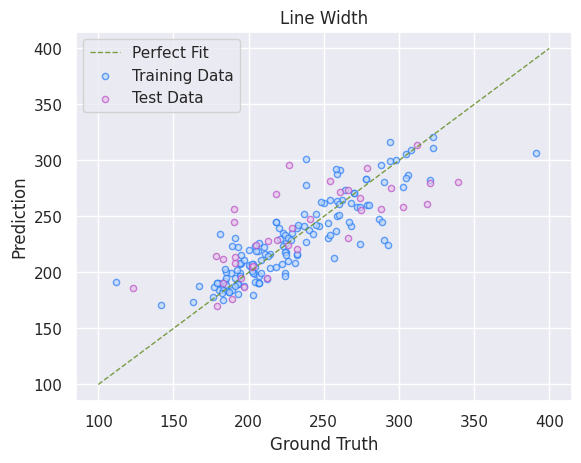

In [115]:
plt.scatter(ds_cleaned.y_train['line_width'], y_train_pred_lw, **plot_param_training)
plt.scatter(ds_cleaned.y_test['line_width'], y_test_pred_lw, **plot_param_test)
x = [100,400]
y = [100,400]
plt.plot(x,y, **plot_param_expected)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Line Width')
plt.legend()
plt.show()

### Roughness

In [17]:
from  src.models.neural_net import NeuralNetConfig, NeuralNet
from src.evaluation.metrics import Metrics, MetricName
config_mlp_relu = NeuralNetConfig(
    ml_platform='sklearn',
    ml_algo='mlp',
    model_params={'alpha': 0.01, 'learning_rate': 0.0001},
    hidden_layer_size=30,
    activation='relu',
    optimizer='lbfgs',
    epochs=500,
    batch_size=32,
    loss='mse',
)
model_mlp_relu_rough = NeuralNet(config_mlp_relu)

In [18]:
model_mlp_relu_rough.train(x_train_norm, ds_cleaned.y_train['roughness'])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09124D+03    |proj g|=  9.64455D+01

At iterate    1    f=  9.23620D+02    |proj g|=  1.37067D+02

At iterate    2    f=  4.72864D+02    |proj g|=  7.55743D+01

At iterate    3    f=  3.26792D+02    |proj g|=  3.42789D+01

At iterate    4    f=  3.00468D+02    |proj g|=  1.04975D+01

At iterate    5    f=  2.97147D+02    |proj g|=  8.57012D+00

At iterate    6    f=  2.90266D+02    |proj g|=  7.08318D+00

At iterate    7    f=  2.82637D+02    |proj g|=  1.00211D+01

At iterate    8    f=  2.76750D+02    |proj g|=  1.12573D+01

At iterate    9    f=  2.71714D+02    |proj g|=  6.98549D+00

At iterate   10    f=  2.67145D+02    |proj g|=  5.06720D+00

At iterate   11    f=  2.58081D+02    |proj g|=  1.19593D+01

At iterate   12    f=  2.53626D+02    |proj g|=  1.33657D+01

At iterate   13    f=  2.4

/home/computeruser/anaconda3/envs/atomic/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [19]:
y_train_pred_rough =  model_mlp_relu_rough.predict(x_train_norm)
y_test_pred_rough =  model_mlp_relu_rough.predict(x_test_norm)

In [21]:
ds_cleaned.data[Features.get_target_columns()[1]]

0      164
1      141
2      103
3       68
4       90
      ... 
183     94
184     86
185     87
186     73
187     45
Name: roughness, Length: 188, dtype: int64

In [22]:
from sklearn.model_selection import cross_val_score
cv_scores_rough = cross_val_score(model_mlp_relu_rough.model, ds_cleaned.data[Features.get_feature_columns()], ds_cleaned.data['roughness'], cv=10) #ds_cleaned.data[Features.get_target_columns()[1]], cv=10)

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98187D+04    |proj g|=  6.23877D+04

At iterate    1    f=  8.88782D+02    |proj g|=  9.33123D+03

At iterate    2    f=  4.39210D+02    |proj g|=  3.00735D+02

At iterate    3    f=  4.38727D+02    |proj g|=  2.45454D+01

At iterate    4    f=  4.38601D+02    |proj g|=  6.81662D+01

At iterate    5    f=  4.37986D+02    |proj g|=  2.10897D+02

At iterate    6    f=  4.36057D+02    |proj g|=  5.02461D+02

At iterate    7    f=  4.31449D+02    |proj g|=  9.25205D+02

At iterate    8    f=  4.18479D+02    |proj g|=  2.84021D+03

At iterate    9    f=  3.84558D+02    |proj g|=  1.70213D+03

At iterate   10    f=  3.80267D+02    |proj g|=  1.38407D+03

At iterate   11    f=  3.64550D+02    |proj g|=  2.56427D+03

At iterate   12    f=  3.59084D+02    |proj g|=  8.01870D+02

At iterate   13    f=  3.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   14    f=  3.90002D+02    |proj g|=  1.27126D+03

At iterate   15    f=  3.87832D+02    |proj g|=  8.91638D+02

At iterate   16    f=  3.84111D+02    |proj g|=  6.04946D+02

At iterate   17    f=  3.83962D+02    |proj g|=  8.22744D+02

At iterate   18    f=  3.83634D+02    |proj g|=  4.52173D+02

At iterate   19    f=  3.83016D+02    |proj g|=  5.15378D+02

At iterate   20    f=  3.82935D+02    |proj g|=  4.20971D+02

At iterate   21    f=  3.82614D+02    |proj g|=  8.57408D+01

At iterate   22    f=  3.82522D+02    |proj g|=  3.15662D+02

At iterate   23    f=  3.82455D+02    |proj g|=  7.31476D+01

At iterate   24    f=  3.82423D+02    |proj g|=  7.69207D+01

At iterate   25    f=  3.82178D+02    |proj g|=  1.62573D+02

At iterate   26    f=  3.82130D+02    |proj g|=  1.01757D+02

At iterate   27    f=  3.82011D+02    |proj g|=  8.35781D+01

At iterate   28    f=  3.81314D+02    |proj g|=  2.44750D+02

At iterate   29    f=  3.77310D+02    |proj g|=  1.04453D+03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate  180    f=  2.88916D+02    |proj g|=  1.96014D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    180    288      1     3     0   1.960D+02   2.889D+02
  F =   288.91558306314465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [23]:
cv_scores_rough

array([-0.16854762,  0.12052318,  0.27815759, -0.00395001,  0.37733126,
        0.1941473 , -0.41227394,  0.4042691 , -0.08945015, -0.25592552])

In [24]:
model_mlp_relu_eval_train_rough = model_mlp_relu_rough.evaluate(x_train_norm, ds_cleaned.y_train['roughness'], evaluation_mat)
model_mlp_relu_eval_test_rough = model_mlp_relu_rough.evaluate(x_test_norm, ds_cleaned.y_test['roughness'], evaluation_mat)

In [25]:
print(model_mlp_relu_eval_train_rough)
print(model_mlp_relu_eval_test_rough)

{'mean_squared_error': 253.43881154282224, 'root_mean_squared_error': 15.91976166727449, 'r2_score': 0.7100098652379917, 'mean_absolute_error': 12.071362374192942, 'median_absolute_error': 9.083028783915452, 'mean_absolute_percentage_error': 13.43702852504146}
{'mean_squared_error': 1673.7786806544445, 'root_mean_squared_error': 40.911840347929164, 'r2_score': -0.44037765160717335, 'mean_absolute_error': 33.23067838021271, 'median_absolute_error': 28.058354578788034, 'mean_absolute_percentage_error': 34.26205384966317}


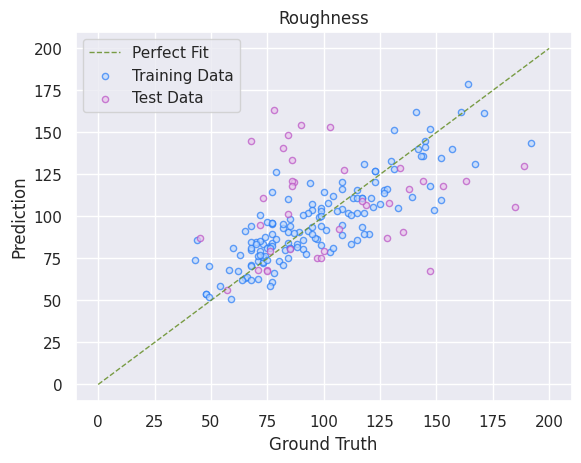

In [28]:
plt.scatter(ds_cleaned.y_train['roughness'], y_train_pred_rough, **plot_param_training)
plt.scatter(ds_cleaned.y_test['roughness'], y_test_pred_rough, **plot_param_test)
x = [00,200]
y = [00,200]
plt.plot(x,y, **plot_param_expected)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Roughness')
plt.legend()
plt.show()

### Overspray

In [39]:
from  src.models.neural_net import NeuralNetConfig, NeuralNet
from src.evaluation.metrics import Metrics, MetricName
config_mlp_relu = NeuralNetConfig(
    ml_platform='sklearn',
    ml_algo='mlp',
    model_params={'alpha': 0.01, 'learning_rate': 0.0001},
    hidden_layer_size=30,
    activation='relu',
    optimizer='lbfgs',
    epochs=500,
    batch_size=32,
    loss='mse',
)
model_mlp_relu_spray = NeuralNet(config_mlp_relu)

In [40]:
model_mlp_relu_spray.train(x_train_norm, ds_cleaned.y_train['overspray'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08717D+04    |proj g|=  1.00086D+02

At iterate    1    f=  5.58841D+03    |proj g|=  1.31288D+02

At iterate    2    f=  5.44912D+03    |proj g|=  8.20888D+01

At iterate    3    f=  5.39325D+03    |proj g|=  8.80340D+01

At iterate    4    f=  5.33443D+03    |proj g|=  6.43036D+01

At iterate    5    f=  5.31126D+03    |proj g|=  3.21758D+01

At iterate    6    f=  5.28129D+03    |proj g|=  3.17758D+01

At iterate    7    f=  5.21191D+03    |proj g|=  3.12617D+01

At iterate    8    f=  5.11740D+03    |proj g|=  3.06110D+01

At iterate    9    f=  5.06688D+03    |proj g|=  1.65068D+01

At iterate   10    f=  5.03931D+03    |proj g|=  1.09326D+01

At iterate   11    f=  5.02463D+03    |proj g|=  1.88942D+01

At iterate   12    f=  5.00050D+03    |proj g|=  1.28626D+01

At iterate   13    f=  4.9

 This problem is unconstrained.
/home/computeruser/anaconda3/envs/atomic/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


At iterate  500    f=  2.04754D+03    |proj g|=  2.24570D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  151    500    569      1     0     0   2.246D+01   2.048D+03
  F =   2047.5435645376372     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [41]:
y_train_pred_spray =  model_mlp_relu_spray.predict(x_train_norm)
y_test_pred_spray =  model_mlp_relu_spray.predict(x_test_norm)

In [42]:
from sklearn.model_selection import cross_val_score
cv_scores_spray = cross_val_score(model_mlp_relu_spray.model, ds_cleaned.data[Features.get_feature_columns()], ds_cleaned.data['overspray'], cv=10)#ds_cleaned.data[Features.get_target_columns()[0]], cv=5)

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78737D+04    |proj g|=  6.55002D+04

At iterate    1    f=  6.98705D+03    |proj g|=  9.54498D+03

At iterate    2    f=  6.51931D+03    |proj g|=  2.24496D+03

At iterate    3    f=  6.51340D+03    |proj g|=  3.14797D+02

At iterate    4    f=  6.51291D+03    |proj g|=  4.44027D+02

At iterate    5    f=  6.51234D+03    |proj g|=  1.43797D+02

At iterate    6    f=  6.51222D+03    |proj g|=  6.98831D+01

At iterate    7    f=  6.51215D+03    |proj g|=  4.79579D+01

At iterate    8    f=  6.51208D+03    |proj g|=  8.45619D+01

At iterate    9    f=  6.51178D+03    |proj g|=  2.07839D+02

At iterate   10    f=  6.51114D+03    |proj g|=  3.74965D+02

At iterate   11    f=  6.50960D+03    |proj g|=  6.33523D+02

At iterate   12    f=  6.50680D+03    |proj g|=  9.45086D+02

At iterate   13    f=  6.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  189    f=  5.69107D+03    |proj g|=  8.23906D+03

At iterate  190    f=  5.68522D+03    |proj g|=  9.19262D+03

At iterate  191    f=  5.68086D+03    |proj g|=  3.32855D+03

At iterate  192    f=  5.67986D+03    |proj g|=  1.07628D+03

At iterate  193    f=  5.67978D+03    |proj g|=  9.38026D+02

At iterate  194    f=  5.67978D+03    |proj g|=  8.11535D+02

At iterate  195    f=  5.67976D+03    |proj g|=  7.93826D+02

At iterate  196    f=  5.67890D+03    |proj g|=  9.57396D+02

At iterate  197    f=  5.67887D+03    |proj g|=  7.98615D+02

At iterate  198    f=  5.67879D+03    |proj g|=  9.57552D+02

At iterate  199    f=  5.67879D+03    |proj g|=  9.61628D+02

At iterate  200    f=  5.67879D+03    |proj g|=  9.61568D+02

At iterate  201    f=  5.67879D+03    |proj g|=  9.61567D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   91    f=  5.86283D+03    |proj g|=  1.64357D+03

At iterate   92    f=  5.86129D+03    |proj g|=  1.63773D+03

At iterate   93    f=  5.85779D+03    |proj g|=  4.31098D+03

At iterate   94    f=  5.85538D+03    |proj g|=  3.88182D+03

At iterate   95    f=  5.85088D+03    |proj g|=  2.31082D+03

At iterate   96    f=  5.85042D+03    |proj g|=  1.00602D+03

At iterate   97    f=  5.84930D+03    |proj g|=  6.34070D+02

At iterate   98    f=  5.84739D+03    |proj g|=  2.46873D+02

At iterate   99    f=  5.84643D+03    |proj g|=  6.76186D+02

At iterate  100    f=  5.84326D+03    |proj g|=  1.65969D+03

At iterate  101    f=  5.84054D+03    |proj g|=  2.80585D+03

At iterate  102    f=  5.83284D+03    |proj g|=  3.72778D+03

At iterate  103    f=  5.82907D+03    |proj g|=  1.85079D+03

At iterate  104    f=  5.82328D+03    |proj g|=  2.95241D+03

At iterate  105    f=  5.82187D+03    |proj g|=  3.76296D+03

At iterate  106    f=  5.82010D+03    |proj g|=  2.22049D+03

At itera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [43]:
cv_scores_spray

array([-0.0810078 ,  0.05316785, -1.00813558, -0.1199101 , -0.55170442,
        0.06749588, -0.25637603, -0.84647113,  0.10766382, -0.12900101])

In [44]:
model_mlp_relu_eval_train_spray = model_mlp_relu_spray.evaluate(x_train_norm, ds_cleaned.y_train['overspray'], evaluation_mat)
model_mlp_relu_eval_test_spray = model_mlp_relu_spray.evaluate(x_test_norm, ds_cleaned.y_test['overspray'], evaluation_mat)

/home/computeruser/research/atomic/my_work/process_property_linkage/src/evaluation/metrics.py:37: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/home/computeruser/research/atomic/my_work/process_property_linkage/src/evaluation/metrics.py:37: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [45]:
print(model_mlp_relu_eval_train_spray)
print(model_mlp_relu_eval_test_spray)


{'mean_squared_error': 4094.173981662073, 'root_mean_squared_error': 63.98573264144182, 'r2_score': 0.6507774144318986, 'mean_absolute_error': 46.759142785734674, 'median_absolute_error': 33.50349522938938, 'mean_absolute_percentage_error': inf}
{'mean_squared_error': 20069.012996070047, 'root_mean_squared_error': 141.66514389951413, 'r2_score': -0.5524980283535776, 'mean_absolute_error': 107.90306807838026, 'median_absolute_error': 76.19120380718823, 'mean_absolute_percentage_error': inf}


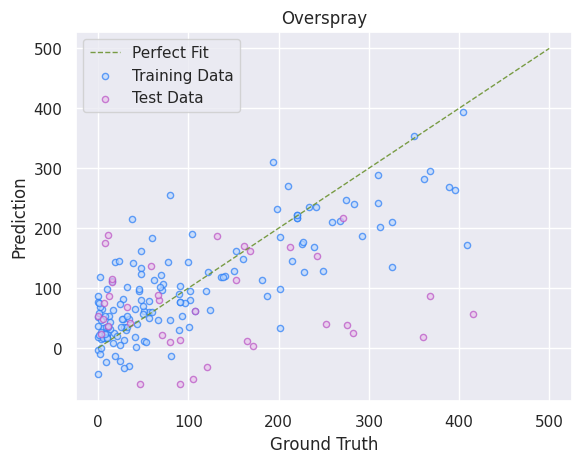

In [46]:
plt.scatter(ds_cleaned.y_train['overspray'], y_train_pred_spray, **plot_param_training)
plt.scatter(ds_cleaned.y_test['overspray'], y_test_pred_spray, **plot_param_test)
x = [00,500]
y = [00,500]
plt.plot(x,y, **plot_param_expected)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title('Overspray')
plt.legend()
plt.show()

# Prediction Algos

In [48]:
def highlight_rows_rmse(row, asking_value):
    cur_value = row.loc['RMSE']
    if cur_value < asking_value:
        color = '#4808c9'
        font_weight = 'normal'
    elif cur_value == asking_value:
        color = '#BAFFC9' 
        font_weight = 'normal'
    else:
        color = '#222222' 
        font_weight = 'normal'
    return [f'color: {color}; font-weight: {font_weight}' for r in row]

## Line width

R2_train = 0.7631930794208385

RSME_train =  21.44942675039149

R2_test = 0.6359015508438468

RSME_test =  24.502041581763386

`paper` : 23.7

In [118]:
#import pyforest
from lazypredict.Supervised import LazyRegressor
from pandas.plotting import scatter_matrix

reg_lazy = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg_lazy.fit(x_train_norm, x_test_norm, ds_cleaned.y_train['line_width'], ds_cleaned.y_test['line_width'])

# models, predictions = reg.fit(x_train_normalized, x_test_normalized, dsy_train['line_width'], y_test['line_width'])

models.reset_index(drop = False, inplace = True)

100%|██████████| 42/42 [00:01<00:00, 35.69it/s]


In [119]:
# HTML(models[['Model','Adjusted R-Squared', 'R-Squared', 'RMSE']].style.apply(lambda x: highlight_rows_rmse(x, 31.50),axis=1).to_html())
HTML(models[['Model','Adjusted R-Squared', 'R-Squared', 'RMSE']].style.apply(lambda x: highlight_rows_rmse(x, model_mlp_relu_eval_test_lw['root_mean_squared_error']),axis=1).to_html())

,Model,Adjusted R-Squared,R-Squared,RMSE
0,GradientBoostingRegressor,0.711104,0.734528,25.401608
1,LGBMRegressor,0.694156,0.718954,26.136091
2,HistGradientBoostingRegressor,0.694156,0.718954,26.136091
3,RANSACRegressor,0.670812,0.697503,27.115193
4,BaggingRegressor,0.664118,0.691351,27.389520
5,PoissonRegressor,0.654254,0.682287,27.788788
6,OrthogonalMatchingPursuitCV,0.636518,0.665989,28.492618
7,LassoLarsIC,0.636099,0.665605,28.509016
8,TransformedTargetRegressor,0.636060,0.665568,28.510560
9,LinearRegression,0.636060,0.665568,28.510560


## Roughness

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
R2_train = 0.4661703381670843

RSME_train =  22.759895306737544

R2_test = 0.1668281136369445

RSME_test =  25.982118043893102

`paper` :  19.4

In [60]:
#import pyforest
from lazypredict.Supervised import LazyRegressor
from pandas.plotting import scatter_matrix

reg_lazy = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg_lazy.fit(x_train_norm, x_test_norm, ds_cleaned.y_train['roughness'], ds_cleaned.y_test['roughness'])
models.reset_index(drop = False, inplace = True)

100%|██████████| 42/42 [00:01<00:00, 35.94it/s]


In [61]:
HTML(models[['Model','Adjusted R-Squared', 'R-Squared', 'RMSE']].style.apply(lambda x: highlight_rows_rmse(x, model_mlp_relu_eval_test_rough['root_mean_squared_error']),axis=1).to_html())

,Model,Adjusted R-Squared,R-Squared,RMSE
0,LGBMRegressor,0.233701,0.295834,28.605431
1,HistGradientBoostingRegressor,0.233701,0.295834,28.605431
2,PoissonRegressor,0.224610,0.287480,28.774607
3,HuberRegressor,0.219937,0.283186,28.861184
4,Lars,0.213506,0.277275,28.979924
5,TransformedTargetRegressor,0.213506,0.277275,28.979924
6,LinearRegression,0.213506,0.277275,28.979924
7,SGDRegressor,0.213222,0.277015,28.985142
8,Ridge,0.213092,0.276895,28.987551
9,OrthogonalMatchingPursuitCV,0.209739,0.273814,29.049230


## Overspray

R2_train = 0.475805274317867

RSME_train =  22.759895306737544

R2_test = -0.3540476835932973

RSME_test =  102.78647489238195

`paper` : 67/129

In [62]:
#import pyforest
from lazypredict.Supervised import LazyRegressor
from pandas.plotting import scatter_matrix

reg_lazy = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg_lazy.fit(x_train_norm, x_test_norm, ds_cleaned.y_train['overspray'], ds_cleaned.y_test['overspray'])
models.reset_index(drop = False, inplace = True)

 17%|█▋        | 7/42 [00:00<00:00, 69.47it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:02<00:00, 19.35it/s]


In [63]:
HTML(models[['Model','Adjusted R-Squared', 'R-Squared', 'RMSE']].style.apply(lambda x: highlight_rows_rmse(x, model_mlp_relu_eval_test_spray['root_mean_squared_error']),axis=1).to_html())

,Model,Adjusted R-Squared,R-Squared,RMSE
0,TransformedTargetRegressor,-0.057455,0.028284,112.077145
1,LinearRegression,-0.057455,0.028284,112.077145
2,Lars,-0.057455,0.028284,112.077145
3,Ridge,-0.057502,0.028242,112.079621
4,SGDRegressor,-0.057521,0.028224,112.080608
5,RidgeCV,-0.058148,0.027647,112.113874
6,PoissonRegressor,-0.061129,0.024908,112.271676
7,BayesianRidge,-0.063292,0.022921,112.386025
8,Lasso,-0.063417,0.022806,112.392622
9,ElasticNetCV,-0.070196,0.016576,112.750324


#  Interpretation

## PDP

### Generalized additive models
- https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

In [64]:
from pygam import LinearGAM, LogisticGAM

In [75]:
ds_cleaned.data.iloc[:, ['print_height'	'nozzle_voltage'	'drop_spacing'	'distance'	'time'	'velocity'	'ink_visco_cp'	'ink_visco_pas'	'surface_tension_dyne_cm'	'surface_tension_n_m'	ink _density	z_number]]

,print_height,nozzle_voltage,drop_spacing,distance,time,velocity,ink_visco_cp,ink_visco_pas,surface_tension_dyne_cm,surface_tension_n_m,ink _density,z_number,line_width,overspray,roughness
0,800,25,8,270,34.00,7.94,6.30,0.01,30.90,0.03,1517,5.04,294,12,164
1,800,25,9,270,34.00,7.94,6.30,0.01,30.90,0.03,1517,5.04,261,136,141
2,800,25,10,300,38.00,7.89,6.30,0.01,30.90,0.03,1517,5.04,218,11,103
3,800,25,11,300,44.00,6.82,6.30,0.01,30.90,0.03,1517,5.04,190,15,68
4,800,25,12,300,41.00,7.32,6.30,0.01,30.90,0.03,1517,5.04,190,91,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,650,31,12,900,96.00,9.38,6.90,0.01,32.30,0.03,1614,4.85,262,17,94
184,650,31,13,900,96.00,9.38,6.90,0.01,32.30,0.03,1614,4.85,241,15,86
185,650,31,14,900,96.00,9.38,6.90,0.01,32.30,0.03,1614,4.85,191,77,87
186,650,31,16,900,108.00,8.33,6.90,0.01,32.30,0.03,1614,4.85,188,1,73


  0% (0 of 188) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (5 of 188) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  5% (10 of 188) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
  7% (15 of 188) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (20 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 12% (24 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (29 of 188) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (34 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (39 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 22% (43 of 188) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 25% (48 of 188) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 28% (53 of 188) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 30% (58 of 188) |#######               

<Figure size 640x480 with 0 Axes>

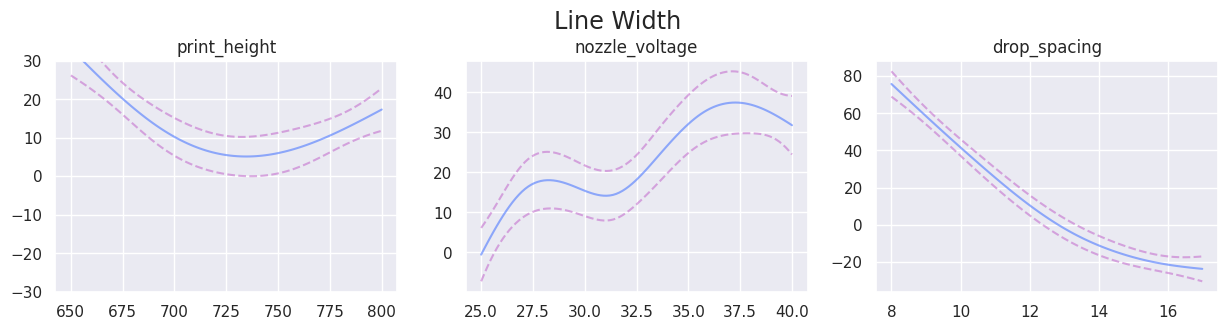

In [120]:
target_to_analyze = 'line_width'

lams = np.random.rand(len(ds_cleaned.data), 3)
lams = lams * 3
lams = np.exp(lams)
gam = LinearGAM(n_splines=10).gridsearch(ds_cleaned.data[ds_cleaned.prop.feature_columns].values, ds_cleaned.data[target_to_analyze].values, lam=lams)


titles = ds_cleaned.prop.feature_columns#redwine.columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,3,figsize=(15, 3))
st = fig.suptitle('Line Width', fontsize='x-large')

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[0], c='#4d79ff99', ls='-')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='#b94fc477', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
    
st.set_y(1.05)
plt.show()

  0% (0 of 188) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (3 of 188) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  4% (8 of 188) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:03
  7% (15 of 188) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (20 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 12% (24 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (29 of 188) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (34 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (39 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 22% (43 of 188) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 25% (48 of 188) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 28% (53 of 188) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 30% (58 of 188) |#######               

<Figure size 640x480 with 0 Axes>

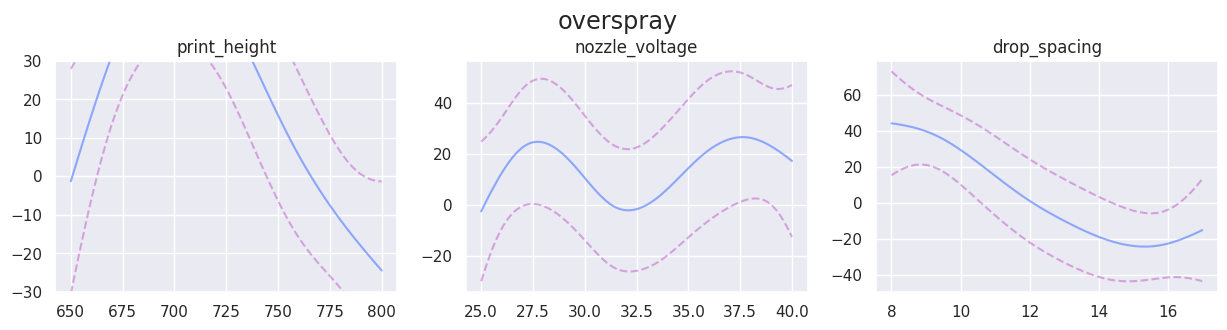

In [121]:
target_to_analyze = 'overspray'

lams = np.random.rand(len(ds_cleaned.data), 3)
lams = lams * 3
lams = np.exp(lams)
gam = LinearGAM(n_splines=10).gridsearch(ds_cleaned.data[ds_cleaned.prop.feature_columns].values, ds_cleaned.data[target_to_analyze].values, lam=lams)


titles = ds_cleaned.prop.feature_columns#redwine.columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,3,figsize=(15, 3))
st = fig.suptitle(target_to_analyze, fontsize='x-large')

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[0], c='#4d79ff99', ls='-')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='#b94fc477', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
    
st.set_y(1.05)
plt.show()

  0% (0 of 188) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (5 of 188) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  5% (10 of 188) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
  7% (15 of 188) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:02
 10% (20 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 12% (24 of 188) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 15% (29 of 188) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (34 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (39 of 188) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 24% (46 of 188) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 28% (53 of 188) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:01
 30% (58 of 188) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:01
 34% (65 of 188) |#######               

<Figure size 640x480 with 0 Axes>

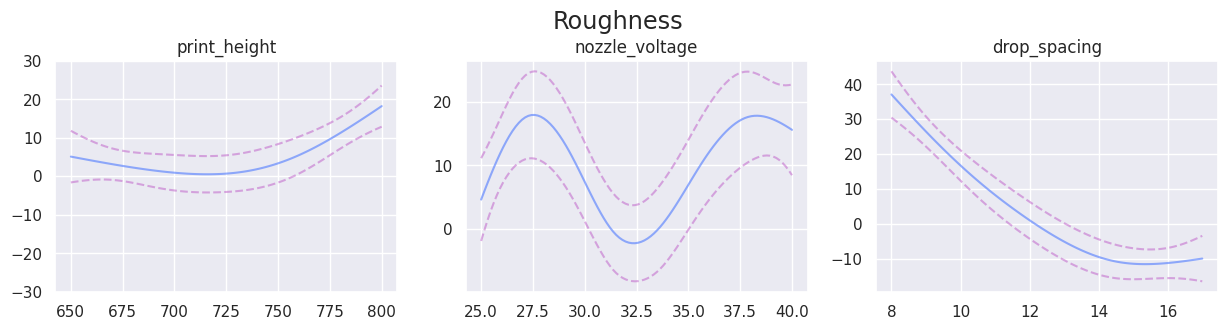

In [123]:
target_to_analyze = 'roughness'

lams = np.random.rand(len(ds_cleaned.data), 3)
lams = lams * 3
lams = np.exp(lams)
gam = LinearGAM(n_splines=10).gridsearch(ds_cleaned.data[ds_cleaned.prop.feature_columns].values, ds_cleaned.data[target_to_analyze].values, lam=lams)


titles = ds_cleaned.prop.feature_columns#redwine.columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,3,figsize=(15, 3))
st = fig.suptitle('Roughness', fontsize='x-large')

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[0], c='#4d79ff99', ls='-')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='#b94fc477', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
    
st.set_y(1.05)
plt.show()

### SHAP

https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

In [126]:
from sklearn import linear_model
import shap
shap.initjs()
from sklearn.metrics import accuracy_score,confusion_matrix
import xgboost as xgb

In [127]:
model_x_lw = xgb.XGBRegressor(objective="reg:squarederror") 
model_x_lw.fit(ds_cleaned.data[ds_cleaned.prop.feature_columns], ds_cleaned.data['line_width'])

explainer_lw = shap.Explainer(model_x_lw)
shap_values_lw = explainer_lw(ds_cleaned.data[ds_cleaned.prop.feature_columns])

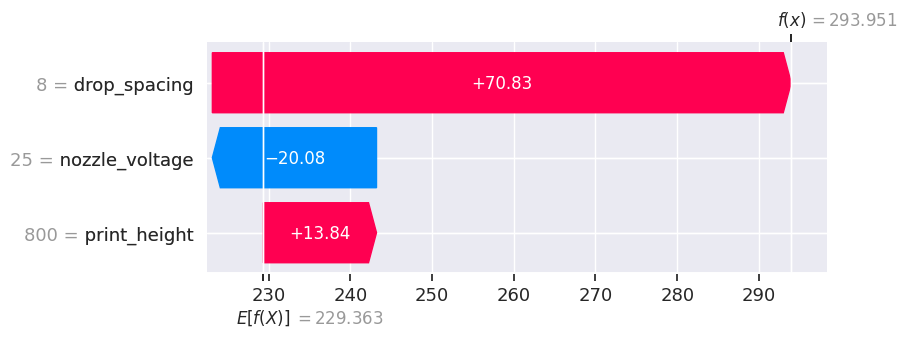

In [129]:
#Observing first instance
shap.plots.waterfall(shap_values_lw[0])

In [130]:
shap.plots.force(shap_values_lw[0])

In [132]:
shap.plots.force(shap_values_lw[0:])

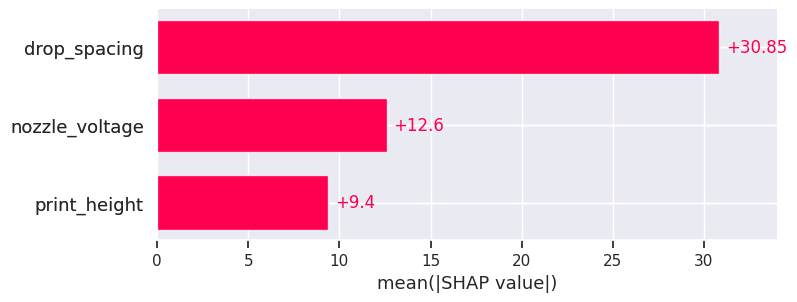

In [133]:
shap.plots.bar(shap_values_lw)

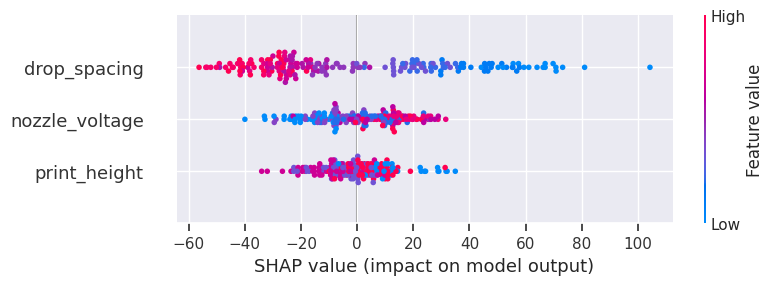

In [134]:
shap.plots.beeswarm(shap_values_lw)

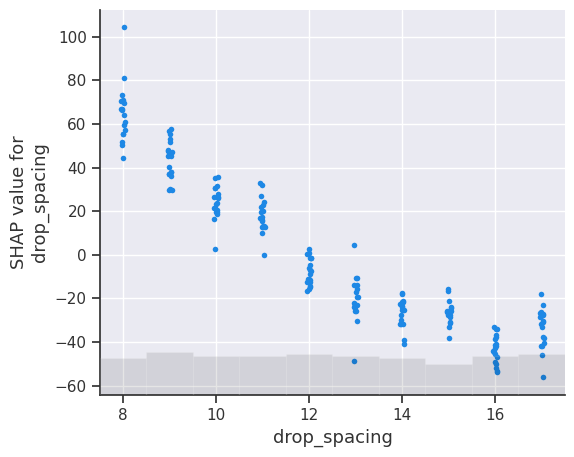

In [136]:
shap.plots.scatter(shap_values_lw[:,"drop_spacing"])

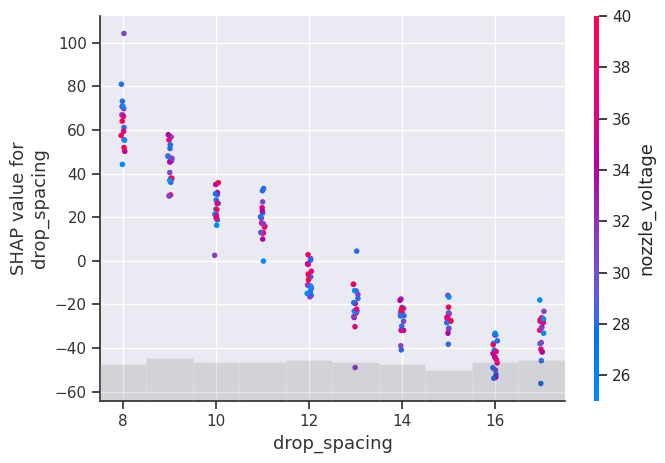

In [137]:
shap.plots.scatter(shap_values_lw[:,"drop_spacing"],
                   color=shap_values_lw[:,"nozzle_voltage"])

#### Interaction

https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

In [140]:
explainer_tree_lw = shap.TreeExplainer(model_x_lw)
shap_interaction_lw = explainer_tree_lw.shap_interaction_values(ds_cleaned.data[ds_cleaned.prop.feature_columns])

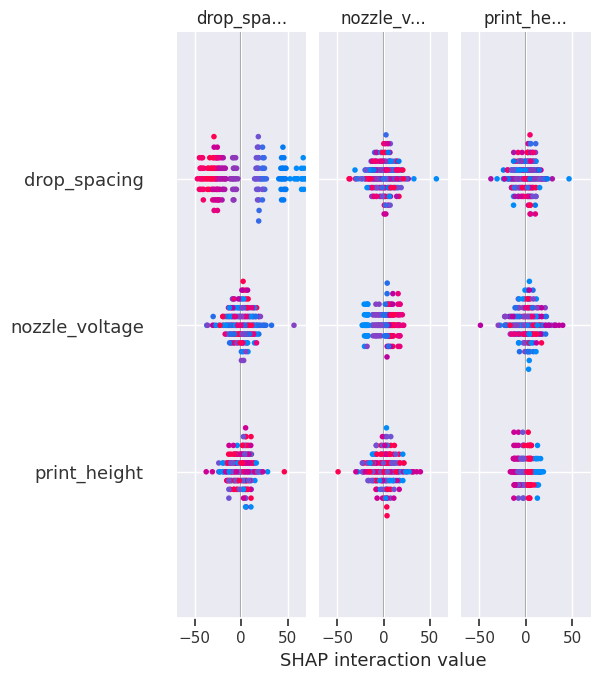

In [141]:
shap.summary_plot(shap_interaction_lw, ds_cleaned.data[ds_cleaned.prop.feature_columns])

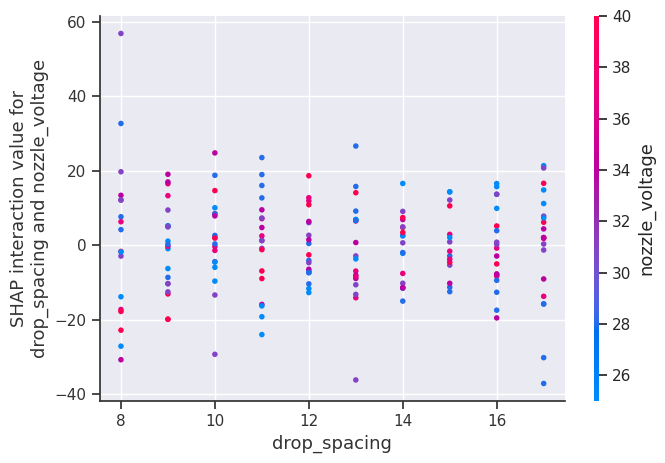

In [143]:
# Dependency plot
shap.dependence_plot(
    ("drop_spacing", "nozzle_voltage"),
    shap_interaction_lw, ds_cleaned.data[ds_cleaned.prop.feature_columns],
    display_features=ds_cleaned.data[ds_cleaned.prop.feature_columns])

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2

In [305]:
!/home/computeruser/anaconda3/envs/atomic/bin/pip install lazypredict

  Using cached lazypredict-0.2.9-py2.py3-none-any.whl (12 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached pandas-1.0.5.tar.gz (5.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... |^C
anceled
ERROR: Operation cancelled by user


In [289]:
import matplotlib
matplotlib.__version__

'3.6.0'

In [25]:
pd.DataFrame([{'ml_algo':1, 'train_acc':2}, {'ml_algo': 100, 'train_acc':200}])

,ml_algo,train_acc
0,1,2
1,100,200


In [44]:
!/home/computeruser/anaconda3/envs/atomic/bin/pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.6 MB/s eta 0:00:00a 0:00:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.0
    Uninstalling joblib-1.0.0:
      Successfully uninstalled joblib-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lazypredict 0.2.9 requires joblib==1.0.0, but you have joblib 1.2.0 which is incompatible.
lazypredict 0.2.9 requires PyYAML==5.4, but you have pyyaml 6.0 which is incompatible.
lazypredict 0.2.9 requires six==1.15.0, but you have six 1.16.0 which is incompatible.


In [49]:
# check version number
#Smooth
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(Print_Database[['Print Height','Nozzle Voltage','Drop Spacing']].add_suffixvalues, Print_Database['Overspray'])

ValueError: "sampling_strategy" can be a float only when the type of target is binary. For multi-class, use a dict.